# Goal
The goal of this notebook is to explore the data within the "releases.csv"
This dataset contains information pertaining to new software releases among open source software.

## Data
The data being explored is the `"release.csv"`

##### Schema
The dataset contains the following columns:
`'id', 'target', 'date', 'date_offset', 'name', 'comment', 'author'`

Some fields relate to a handful of other datasets (directory info, snapshots, servers). The extra data is unnseccecary for our purposes.

## Challenges
##### Large Dataset
The full dataset is large (1.4 Gigs). A teaser dataset is being used to explore properties of the data.
##### Unclear Connection
We wish to compare this dataset with another set, NVD, which contains information about discovered software vulnerabilities.
It may be possible to directly relate and connect the two datasets. This requires exploring of the two sets.

Alternatively, we can always correlate the two.





# Code
Simple imports

Declaring column headers and path to the data (on my machine)

In [17]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.figsize"] = [16,9]

In [2]:
release_header = ['id', 'target', 'date', 'date_offset', 'name', 'comment', 'author']
revision_header = ['id', 'date', 'committer_date', 'directory', 'message', 'author', 'committer']
release_path = 'D:/data/open_source/release.csv.gz'

Some fields are stored as hexidecimal strings, this function converts it to decimal.

Also, a function to convert the incoming date string to a dateitme object.

In [3]:
def hex_str(str):
    return bytes.fromhex((str).replace('\\x','')).decode('utf-8')

def date_str(str):
    return pd.to_datetime(str, format='%Y-%m-%dT%H:%M:%S.000Z')

The data is read in and only the useful columns are kept

In [4]:
release_df = pd.read_csv(release_path, names=release_header, converters={'date':date_str,'comment':hex_str})
release_df = release_df[['id','date','name','comment','author']]

Here the data is organized by date into the amount of releases pushed per hour. This is then graphed.

In [5]:
releases_per_hour = (release_df[['date','id']].set_index('date').resample('H').count()).rename(columns={'id':'count'})

In [6]:
releases_per_hour

,count
date,
2005-09-16 23:00:00,1
2005-09-17 00:00:00,0
2005-09-17 01:00:00,0
2005-09-17 02:00:00,0
2005-09-17 03:00:00,0
...,...
2018-09-22 16:00:00,0
2018-09-22 17:00:00,0
2018-09-22 18:00:00,0


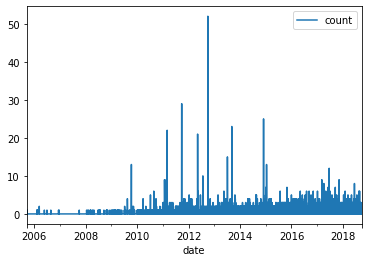

In [7]:
releases_per_hour.plot()

Here we see spikes in the data. This will need to be explored further.

It is possible that these spikes in `hourly` release rate is due to a response to an extreme vulnerability. This could also be due to various other factors, such as github/others servers crashing, and only pushing releases after coming back online.

In [8]:
releases_per_hour[ releases_per_hour.values > 10 ]

,count
date,
2009-10-10 15:00:00,13
2011-03-02 21:00:00,22
2011-09-25 01:00:00,29
2011-09-25 02:00:00,19
2012-05-08 01:00:00,21
2012-09-30 04:00:00,52
2013-07-05 05:00:00,15
2013-09-05 08:00:00,23
2014-11-30 09:00:00,25


In [9]:
def date_str_nvd(str):
    return pd.to_datetime( str, format='%Y-%m-%dT%H:%MZ')

In [10]:
nvd_12_df = pd.read_json('D:/data/open_source/NVD/nvdcve-1.1-2012.json.gz')

In [11]:
nvd_12_df

,CVE_data_type,CVE_data_format,CVE_data_version,CVE_data_numberOfCVEs,CVE_data_timestamp,CVE_Items
0,CVE,MITRE,4,5559,2019-09-10T00:12Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."
1,CVE,MITRE,4,5559,2019-09-10T00:12Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."
2,CVE,MITRE,4,5559,2019-09-10T00:12Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."
3,CVE,MITRE,4,5559,2019-09-10T00:12Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."
4,CVE,MITRE,4,5559,2019-09-10T00:12Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."
...,...,...,...,...,...,...
5554,CVE,MITRE,4,5559,2019-09-10T00:12Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."
5555,CVE,MITRE,4,5559,2019-09-10T00:12Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."
5556,CVE,MITRE,4,5559,2019-09-10T00:12Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."
5557,CVE,MITRE,4,5559,2019-09-10T00:12Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."


Almost all of the important information is contained in the `CVE_Items` field.

Such as the published date of the vulnerability, contained within the json, as seen below:

In [12]:
nvd_12_df['CVE_Items'][1]['publishedDate']

'2012-03-13T21:55Z'

Here we go through the rows, pulling out the date as a dateitme object, and assigning a new column to hold the value.

In [13]:
nvd_12_df['date'] = nvd_12_df['CVE_Items'].apply( lambda x: date_str_nvd(x['publishedDate']) )

In [14]:
nvd_12_df

,CVE_data_type,CVE_data_format,CVE_data_version,CVE_data_numberOfCVEs,CVE_data_timestamp,CVE_Items,date
0,CVE,MITRE,4,5559,2019-09-10T00:12Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2012-01-10 21:55:00
1,CVE,MITRE,4,5559,2019-09-10T00:12Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2012-03-13 21:55:00
2,CVE,MITRE,4,5559,2019-09-10T00:12Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2012-01-10 21:55:00
3,CVE,MITRE,4,5559,2019-09-10T00:12Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2012-01-10 21:55:00
4,CVE,MITRE,4,5559,2019-09-10T00:12Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2012-01-10 21:55:00
...,...,...,...,...,...,...,...
5554,CVE,MITRE,4,5559,2019-09-10T00:12Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2019-08-21 18:15:00
5555,CVE,MITRE,4,5559,2019-09-10T00:12Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2019-08-22 13:15:00
5556,CVE,MITRE,4,5559,2019-09-10T00:12Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2019-08-28 12:15:00
5557,CVE,MITRE,4,5559,2019-09-10T00:12Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2019-08-28 12:15:00


In [15]:
vulns_per_hour = (nvd_12_df[['date','CVE_data_type']].set_index('date').resample('H').count()).rename(columns={'CVE_data_type':'count'})

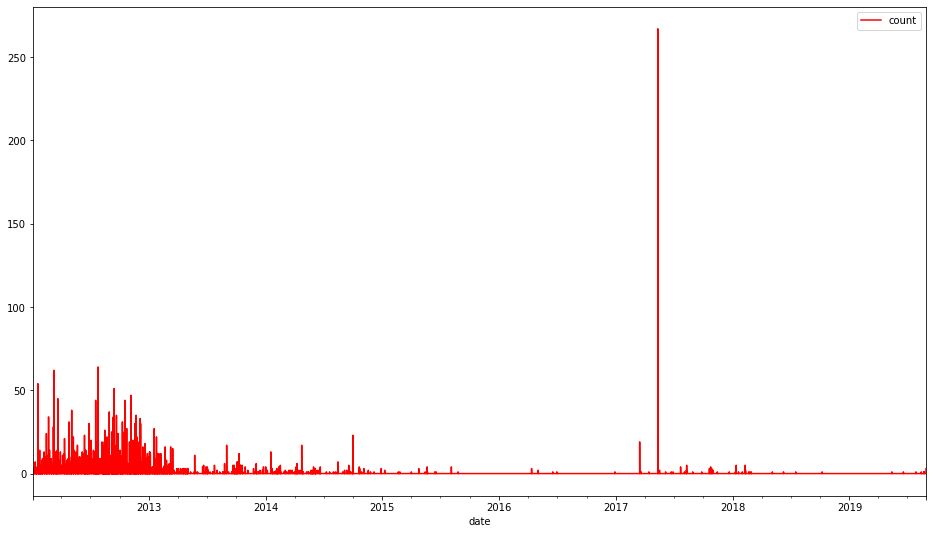

In [18]:
vulns_per_hour.plot(color="red")

Huh... it looks like the NVD dataset has vlnerabilites from 2012 to 2019 ? Uh, sure

Next step is to fish out the severe vulnerabilities, and see if the release date closesly predicts an increase in releases.

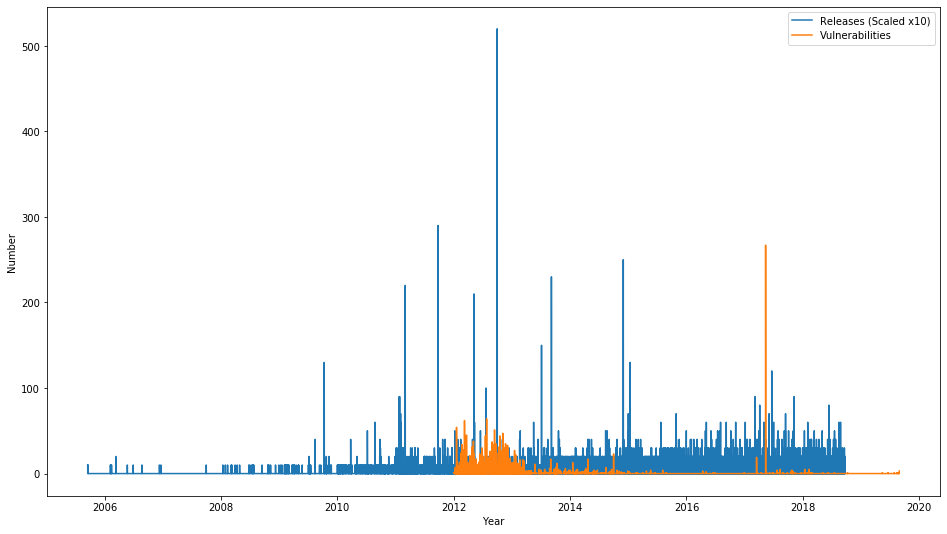

In [32]:
plt.plot(releases_per_hour*10, label="Releases (Scaled x10)")
plt.plot(vulns_per_hour, label="Vulnerabilities")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Number")
plt.show()